# Do Zip Codes with Large Parks have Higher Dog Density than those without? Are the dog and cat populations different ages? 
## Hypothesis Testing Reminder/Primer with Python's Stats Package, and other things you never thought to ask about registered pets in Seattle

## Import necessary packages

In [261]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

## Load data from csv

Note: seattle_zip_code_pet_density.csv is generated in this[https://github.com/allisonhonold/geospatial_data_blog/blob/master/geospatial_blog.ipynb] jupyter notebook. See below for the conversion from string to shapely geometry

In [262]:
pets_zips = pd.read_csv('data/seattle_zip_code_pet_density.csv')
pets = pd.read_csv('data/Seattle_Pet_Licenses.csv')

In [263]:
pets_zips.head()

,Unnamed: 0,ZIP,geometry,area,pets,pet_density
0,0,98101,POLYGON ((-122.3278536012117 47.61849675280555...,0.000163,696,4.259932e+06
1,1,98102,POLYGON ((-122.3123241071172 47.64705007992422...,0.000481,1640,3.412311e+06
2,2,98112,MULTIPOLYGON (((-122.3068257351625 47.64729480...,0.000981,1895,1.932635e+06
3,3,98115,POLYGON ((-122.2729415289972 47.70106980982185...,0.002019,4541,2.249664e+06
4,4,98116,"POLYGON ((-122.381388745373 47.59054151926219,...",0.000905,2366,2.615165e+06


In [264]:
pets.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,April 19 2003,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116
1,February 07 2006,75432,Pepper,Cat,Manx,Mix,98103
2,May 21 2014,727943,Ashley,Cat,Domestic Shorthair,NaN,98115
3,May 08 2015,833836,Lulu,Cat,LaPerm,NaN,98136
4,May 13 2015,361031,My Boy,Cat,Russian Blue,NaN,98121


## Import Shape Files for Seattle Parks

In [265]:
parks_gdf = gpd.read_file('data/shapes/Seattle_Parks.shp')

In [266]:
parks_gdf.head()

,OBJECTID,NAME,PMA_NAME,ADDRESS,PIN,SUBPARCEL,PMA,OWNER,LEASE,MAINT,USE,ACQ_DATE,NAMEFLAG,SE_ANNO_CA,REVIEW_DAT,AMWOID,GIS_EDT_DT,SHAPE_Leng,SHAPE_Area,geometry
0,1,JACKSON PARK GOLF COURSE,Jackson Park Golf Course,None,5101407870,636.0,327,DPR,N,DPR,GF,2099-01-01T00:00:00.000Z,5.0,None,1899-12-30T00:00:00.000Z,PROPERTY-JGOLF,2016-06-09T16:23:26.000Z,10475.262003,5.778501e+06,"POLYGON ((-122.32336 47.73397, -122.32300 47.7..."
1,2,BURKE-GILMAN TRAIL,Burke-Gilman Trail,None,2226049009,675.0,476,DPR,N,DPR,TR,2099-01-01T00:00:00.000Z,9.0,None,1899-12-30T00:00:00.000Z,PROPERTY-BGTR,2016-06-09T16:23:26.000Z,6043.377984,1.484822e+05,"POLYGON ((-122.28477 47.73374, -122.28467 47.7..."
2,3,LITTLE BROOK PARK,Little Brook Park,None,7663700850,1663.0,297,DPR,N,DPR,PK,1994-12-06T00:00:00.000Z,2.0,None,2004-05-26T00:00:00.000Z,PROPERTY-LIBRPK,2016-06-09T16:23:26.000Z,867.560578,3.860706e+04,"POLYGON ((-122.29519 47.73156, -122.29511 47.7..."
3,4,HELENE MADISON POOL,Helene Madison Pool,None,1926049035,525.0,285,None,None,DPR,PL,2099-01-01T00:00:00.000Z,2.0,None,1899-12-30T00:00:00.000Z,PROPERTY-MADPLGR,2016-06-09T16:23:26.000Z,1815.443199,1.833490e+05,"POLYGON ((-122.33556 47.72677, -122.33432 47.7..."
4,5,MAGNOLIA BOULEVARD,Magnolia Boulevard,None,2225039999,674.0,2843,DPR,None,DPR,BV,2099-01-01T00:00:00.000Z,9.0,None,1899-12-30T00:00:00.000Z,PROPERTY-MGLBL,2016-06-09T16:23:26.000Z,5879.161653,3.602566e+05,"POLYGON ((-122.41446 47.64678, -122.41433 47.6..."


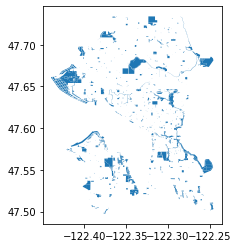

In [267]:
parks_gdf.plot()

## Convert Zip Code geometry from string to shapely / geopandas

In [268]:
from shapely import wkt
pets_zips['geometry'] = pets_zips['geometry'].apply(wkt.loads)
pets_zips_gdf = gpd.GeoDataFrame(pets_zips, geometry='geometry')

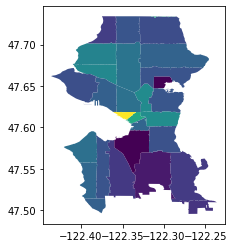

In [269]:
pets_zips_gdf.plot(column='pet_density')

## Classify Parks into Zip Codes

In [270]:
for zip_code in pets_zips_gdf['ZIP']:
    # get the geometry of the zipcode
    zip_code_geometry = pets_zips_gdf.loc[pets_zips['ZIP'] == zip_code, 'geometry']
    zip_code_geometry = zip_code_geometry.reset_index(drop=True)
    
    # check if each park is in the zipcode, store result
    parks_gdf[str(zip_code)] = parks_gdf.intersects(zip_code_geometry[0])

In [271]:
parks_gdf.head(1).T

,0
OBJECTID,1
NAME,JACKSON PARK GOLF COURSE
PMA_NAME,Jackson Park Golf Course
ADDRESS,None
PIN,5101407870
SUBPARCEL,636
PMA,327
OWNER,DPR
LEASE,N
MAINT,DPR


## Decide on "Large Park" Boundary and Get "large parks" zipcodes

Ravenna park's size: 50 acres

In [272]:
ravenna_park = parks_gdf.loc[parks_gdf['NAME'] == 'RAVENNA PARK']
large_park_area = ravenna_park['SHAPE_Area'].sum()

In [273]:
large_parks = parks_gdf.loc[parks_gdf['SHAPE_Area']>= large_park_area]

In [274]:
large_parks.head(1).T

,0
OBJECTID,1
NAME,JACKSON PARK GOLF COURSE
PMA_NAME,Jackson Park Golf Course
ADDRESS,None
PIN,5101407870
SUBPARCEL,636
PMA,327
OWNER,DPR
LEASE,N
MAINT,DPR


In [275]:
parks_in_zips = {zip_code: large_parks[str(zip_code)].sum() for zip_code in pets_zips_gdf['ZIP']}

In [276]:
parks_in_zips

{98101: 0,
 98102: 0,
 98112: 1,
 98115: 2,
 98116: 1,
 98136: 1,
 98103: 3,
 98104: 0,
 98105: 0,
 98106: 2,
 98107: 0,
 98108: 2,
 98109: 0,
 98118: 4,
 98119: 0,
 98121: 0,
 98122: 0,
 98125: 1,
 98126: 2,
 98133: 0,
 98134: 0,
 98144: 1,
 98146: 0,
 98155: 1,
 98117: 0,
 98177: 2,
 98178: 0,
 98199: 3,
 98195: 0}

In [277]:
no_parks_zips = [zip_code for zip_code in parks_in_zips.keys() if parks_in_zips[zip_code]==0]

In [278]:
parks_zips = [zip_code for zip_code in parks_in_zips.keys() if parks_in_zips[zip_code]>0]

In [279]:
print(f"Number of zip codes without large parks: {len(no_parks_zips)}")
print(f"Number of zip codes with large parks: {len(parks_zips)}")

Number of zip codes without large parks: 15
Number of zip codes with large parks: 14


## Calculate Dog Density

Clean data frame zip codes

In [280]:
# cut 9-digit zipcodes to the 5-digit version
pets['ZIP Code'] = pets['ZIP Code'].str[0:5]

# drop rows with NaN zip codes (~400 of 51k)
pets = pets.dropna(subset=['ZIP Code'])

# cast str zip codes to ints to match geo-dataset
pets['ZIP Code'] = pets['ZIP Code'].astype(int)

Calculate dog counts

In [281]:
# create dataframe with the count of pets by zipcode
dog_df = pets.loc[pets['Species'] == 'Dog']
dog_counts = pd.DataFrame(dog_df['ZIP Code'].value_counts())
dog_counts = dog_counts.reset_index()
dog_counts.columns = ['ZIP', 'dog_count']

Add dog data to pets_zips_gdf

In [282]:
pets_zips_gdf = pets_zips_gdf.merge(dog_counts, on='ZIP')

In [283]:
pets_zips_gdf['dog_density'] = pets_zips_gdf['dog_count'] / pets_zips_gdf['area']

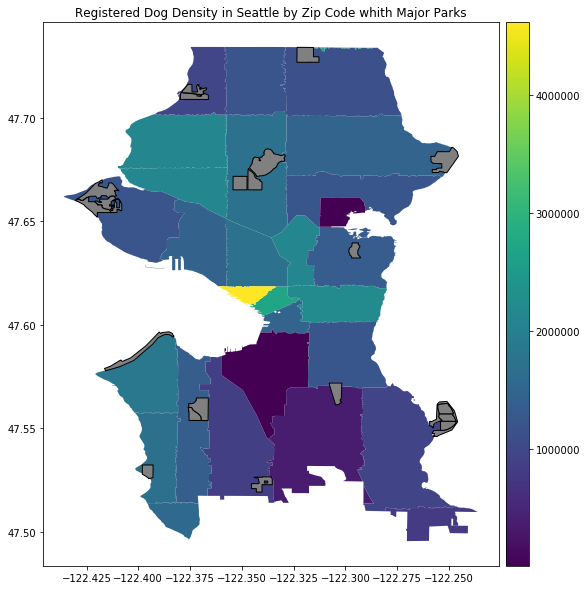

In [330]:
# adding a legend using code from http://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_title('Registered Dog Density in Seattle by Zip Code whith Major Parks')
pets_zips_gdf.plot(column='dog_density', ax=ax, cax=cax, legend=True)
large_parks.plot(ax=ax, color='gray', edgecolor='black')

plt.savefig('images/goat_map.png');

## Hypothesis Testing

### Do zipcodes with large parks have a higher density of dogs than those without large parks?

In [285]:
park_zips_dogs = pets_zips_gdf.loc[pets_zips_gdf['ZIP'].isin(parks_zips)]

In [286]:
no_park_zips_dogs = pets_zips_gdf.loc[pets_zips_gdf['ZIP'].isin(no_parks_zips)]

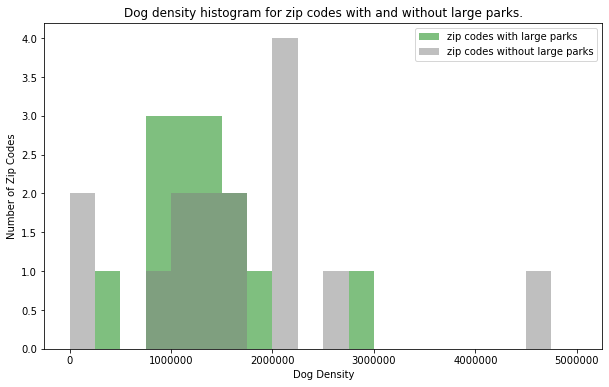

In [315]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(park_zips_dogs['dog_density'], color='g', 
        bins=20, range=(0, 5000000), alpha=.5, label='zip codes with large parks')
ax.hist(no_park_zips_dogs['dog_density'], color='gray', 
        bins=20, range=(0, 5000000), alpha=.5, label='zip codes without large parks')
ax.legend()
ax.set_xlabel('Dog Density')
ax.set_ylabel('Number of Zip Codes')
ax.set_title('Dog density histogram for zip codes with and without large parks.')
plt.savefig('images/park_zip_hist.png');

In [288]:
from scipy.stats import ttest_ind, t
import numpy as np

In [289]:
rand_no_parks_zips = np.random.choice(no_parks_zips, size=14)

In [290]:
result = ttest_ind(rand_no_parks_zips, parks_zips, equal_var=False)
print(result)

Ttest_indResult(statistic=-0.4017121268473959, pvalue=0.6911797046981514)


In [291]:
p = .95 # 1-alpha
df = 13 # degrees of freedom (n-1)
critical_t_value = t.ppf(p, df)
critical_t_value

1.7709333959867988

In [292]:
p_value = t.cdf(result[0], df)
p_value

0.3472109240283714

### Do cats and dogs have different "residence" time in Seattle right now?

In [293]:
pets.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,April 19 2003,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116
1,February 07 2006,75432,Pepper,Cat,Manx,Mix,98103
2,May 21 2014,727943,Ashley,Cat,Domestic Shorthair,NaN,98115
3,May 08 2015,833836,Lulu,Cat,LaPerm,NaN,98136
4,May 13 2015,361031,My Boy,Cat,Russian Blue,NaN,98121


In [294]:
pets['License Issue Date'] = pd.to_datetime(pets['License Issue Date'])

In [295]:
import datetime

In [296]:
today = datetime.datetime.today()
pets['time_in_sea'] = today - pets['License Issue Date']

In [297]:
pets.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code,time_in_sea
0,2003-04-19,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116,6083 days 15:04:59.512174
1,2006-02-07,75432,Pepper,Cat,Manx,Mix,98103,5058 days 15:04:59.512174
2,2014-05-21,727943,Ashley,Cat,Domestic Shorthair,NaN,98115,2033 days 15:04:59.512174
3,2015-05-08,833836,Lulu,Cat,LaPerm,NaN,98136,1681 days 15:04:59.512174
4,2015-05-13,361031,My Boy,Cat,Russian Blue,NaN,98121,1676 days 15:04:59.512174


In [298]:
pets['time_in_sea'] = [x.days for x in pets['time_in_sea']]

In [299]:
cats = pets.loc[pets['Species'] == 'Cat']

In [300]:
cats.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code,time_in_sea
0,2003-04-19,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116,6083
1,2006-02-07,75432,Pepper,Cat,Manx,Mix,98103,5058
2,2014-05-21,727943,Ashley,Cat,Domestic Shorthair,NaN,98115,2033
3,2015-05-08,833836,Lulu,Cat,LaPerm,NaN,98136,1681
4,2015-05-13,361031,My Boy,Cat,Russian Blue,NaN,98121,1676


In [301]:
dogs = pets.loc[pets['Species'] == 'Dog']

In [302]:
dogs.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code,time_in_sea
16872,2011-03-29,141222,Jenkey,Dog,Australian Cattle Dog,Mix,98106,3182
16873,2014-08-25,728371,Emma,Dog,Beagle,NaN,98102,1937
16874,2014-12-02,140940,Lulu,Dog,"Retriever, Golden","Poodle, Standard",98118,1838
16875,2015-05-08,731184,Ginger,Dog,"Chihuahua, Short Coat",NaN,98136,1681
16876,2015-08-05,S102297,Frida,Dog,"Chihuahua, Short Coat",Mix,98117,1592


In [303]:
print(f"oldest dog: {dogs['time_in_sea'].max()} ")
print(f"oldest cat: {cats['time_in_sea'].max()}" )

oldest dog: 4286 
oldest cat: 6083


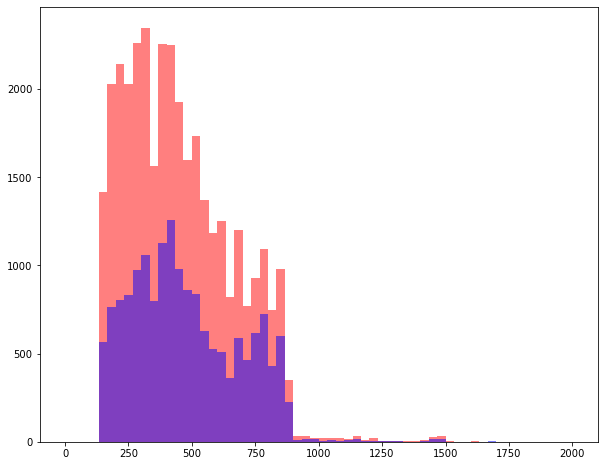

In [304]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(dogs['time_in_sea'], color='r', 
        bins=60, range=(0, 2000), alpha=.5)
ax.hist(cats['time_in_sea'], color='b', 
        bins=60, range=(0, 2000), alpha=.5);

Oh no! It looks like days since liscence issue date is not a good proxy for pet age. There must have been a change of system or licensing push around three years ago (2007).

## Visualizing the difference between one-tailed and two-tailed t-tests

In [305]:
# set degree of freedom and critical value for .05 significance level
df = 20
t_crit_one_tail_greater = t.ppf(.95, df)
t_crit_one_tail_less = t.ppf(.05, df)
t_crit_two_tails_upper = t.ppf(0.975, df)
t_crit_two_tails_lower = t.ppf(0.025, df)

# generate x and y values
x = np.linspace(-5, 5, 200)
y = t.pdf(x, df)

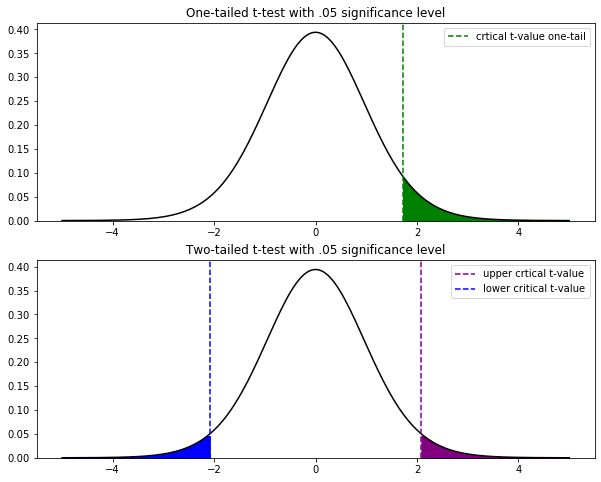

In [306]:
# plot for one-tailed t-test
fig, axs = plt.subplots(nrows=2, figsize=(10,8))
axs[0].plot(x, y, color='black')

# add .05 significance level for a one-tailed t-test
axs[0].axvline(t_crit_one_tail_greater, label='crtical t-value one-tail',
          color='g', linestyle='--')
axs[0].fill_betweenx(y, x, t_crit_one_tail_greater, 
                 where= x > t_crit_one_tail_greater,
                 color='g')
axs[0].legend()
axs[0].set_ylim(bottom=0)
axs[0].set_title('One-tailed t-test with .05 significance level')


# plot for two-tailed t-test
axs[1].plot(x, y, color='black')

# add .05 significance level for a two-tailed t-test
axs[1].axvline(t_crit_two_tails_upper, label='upper crtical t-value',
          color='purple', linestyle='--')
axs[1].fill_betweenx(y, x, t_crit_two_tails_upper, 
                 where= x > t_crit_two_tails_upper, color='purple')
axs[1].axvline(t_crit_two_tails_lower, label='lower critical t-value',
          color='blue', linestyle='--')
axs[1].fill_betweenx(y, x, t_crit_two_tails_lower, 
                 where= x < t_crit_two_tails_lower,
                color='blue')
axs[1].legend()
axs[1].set_ylim(bottom=0)
axs[1].set_title('Two-tailed t-test with .05 significance level')
plt.savefig('images/one_v_two_tailed_t_test.png');

## Miniature Goats in Seattle

In [307]:
goats = pets.loc[pets['Species'] == 'Goat']

In [308]:
goats.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code,time_in_sea
322,2017-07-18,S142812,Nani,Goat,Miniature,NaN,98112,879
432,2017-08-02,S133784,Beans,Goat,Miniature,NaN,98106,864
1285,2017-09-22,S136146,Abelard,Goat,Miniature,NaN,98112,813
1286,2017-09-22,S136147,Olive,Goat,Miniature,NaN,98112,813
1885,2017-10-26,S137110,Piper,Goat,Miniature,NaN,98125,779


In [309]:
goat_zip_counts = pd.DataFrame(goats['ZIP Code'].value_counts())
goat_zip_counts = goat_zip_counts.reset_index()
goat_zip_counts.columns = ['ZIP', 'goats']
goat_zip_counts

,ZIP,goats
0,98108,5
1,98115,5
2,98133,4
3,98125,4
4,98112,4
5,98106,3
6,98122,3
7,98118,3
8,98117,2
9,98178,2


In [310]:
pets_zips_gdf = pets_zips_gdf.merge(goat_zip_counts, on='ZIP', how='left')

In [311]:
pets_zips_gdf['goats'] = pets_zips_gdf['goats'].fillna(0)

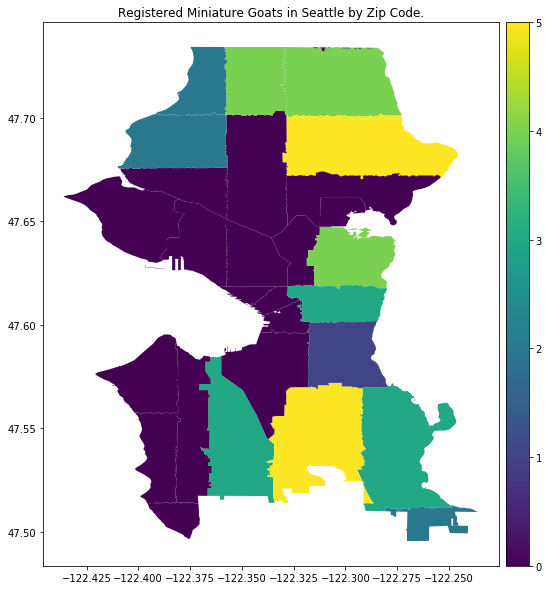

In [332]:
# adding a legend using code from http://geopandas.org/mapping.html
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pets_zips_gdf.plot(column='goats', ax=ax, cax=cax, legend=True)
ax.set_title('Registered Miniature Goats in Seattle by Zip Code.')
plt.savefig('images/goat_map.png');